In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
!python -m spacy download en_core_web_sm

     --------------------------------------- 12.8/12.8 MB 15.9 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
# Load spacy English languague model
NER = spacy.load("en_core_web_sm")

In [4]:
##Load books   

import os

# Import all book files in the data directory
all_books = [b for b in os.scandir('data') if '.txt' in b.name]
all_books

[<DirEntry 'B - The Sword of Destiny.txt'>,
 <DirEntry 'C - The Last Wish.txt'>,
 <DirEntry 'E - something ends something begins.txt'>,
 <DirEntry 'I - Blood of Elves.txt'>,
 <DirEntry 'II - Times of Contempt.txt'>,
 <DirEntry 'III - Baptism of Fire.txt'>,
 <DirEntry 'IV - The Tower of the Swallow.txt'>,
 <DirEntry 'V - The Lady of the Lake.txt'>]

In [5]:
book = all_books[0]
book_text = open(book).read()
book_doc = NER(book_text)

In [6]:
# Visualize identified entities
displacy.render(book_doc[0:2000], style="ent",jupyter=True)

In [7]:
# Read characters
character_df = pd.read_csv("characters.csv", delimiter=',')
character_df

,book,character
0,Category:Baptism of Fire characters,Adalia
1,Category:Baptism of Fire characters,Adela
2,Category:Baptism of Fire characters,Aen Saevherne
3,Category:Baptism of Fire characters,Aevenien
4,Category:Baptism of Fire characters,Aglaïs
...,...,...
1269,Category:Time of Contempt characters,Yanna of Murivel
1270,Category:Time of Contempt characters,Yarpen Zigrin
1271,Category:Time of Contempt characters,Yennefer of Vengerberg
1272,Category:Time of Contempt characters,Yiolenta Suarez


In [8]:
# Removing brackets and text within brackets
import re
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x))
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split (' ',1)[0])


In [9]:
## Get named entity list per sentence

sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})

sent_entity_df = pd.DataFrame(sent_entity_df)

In [10]:
sent_entity_df

,sentence,entities
0,"(ď»żThe, Limits, of, the, Possible, \n, I, \n)",[ď»żThe Limits of the Possible\nI\n]
1,"("", He, 's, not, coming, back, out, ,, I, tell...",[]
2,"("", It, 's, been, an, hour, and, a, quarter, s...",[an hour and a quarter]
3,"(He, 's, done, for, .)",[]
4,"("", \n, The, townsfolk, ,, huddled, together, ...",[]
...,...,...
11304,"(I, 'm, your, destiny, ?, "", \n, Yurga, saw, a...",[]
11305,"(He, heard, Chrysididae, 's, discreet, sobs, a...",[]
11306,"(He, knew, that, he, would, not, understand, t...",[]
11307,"(With, good, reason, :, \n, "", You, 're, more,...",[Ciri]


In [11]:
# Function to filter out non-character entities
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list
        if ent in list(character_df.character)
        or ent in list(character_df.character_firstname)]

In [12]:
filter_entity(["Geralt", "Thu", "2"], character_df)

['Geralt']

In [13]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

#filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
97,"(Is, there, anything, keeping, you, in, this, ...","[Geralt, Rivia]",[Geralt]
105,"("", \n, "", Borch, ,, "", replied, Geralt, ,, wh...","[Borch, Geralt]",[Geralt]
109,"("", \n, "", There, are, some, ,, "", Geralt, rep...",[Geralt],[Geralt]
141,"("", I, forgot, ,, "", Three, Jackdaws, winked, ...","[Three, Geralt]",[Geralt]
152,"(Geralt, loosened, his, belt, ,, removed, his,...",[Geralt],[Geralt]
158,"("", Do, the, girls, speak, the, common, langua...",[Geralt],[Geralt]
161,"(How, 's, your, soup, ,, Geralt, ?, "", \n, "", ...",[Geralt],[Geralt]
173,"(Yet, there, is, a, certain, principal, underl...",[Geralt],[Geralt]
202,"("", Bad, example, ,, "", interrupted, Geralt, .)","[Bad, Geralt]",[Geralt]
212,"("", I, do, not, hunt, dragons, ,, "", Geralt, r...",[Geralt],[Geralt]


In [14]:
#take only first name of characters
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
                                                                                                                for item in x])

C:\Users\Laptop\AppData\Local\Temp\ipykernel_7756\2019164323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


In [15]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered

,sentence,entities,character_entities
97,"(Is, there, anything, keeping, you, in, this, ...","[Geralt, Rivia]",[Geralt]
105,"("", \n, "", Borch, ,, "", replied, Geralt, ,, wh...","[Borch, Geralt]",[Geralt]
109,"("", \n, "", There, are, some, ,, "", Geralt, rep...",[Geralt],[Geralt]
141,"("", I, forgot, ,, "", Three, Jackdaws, winked, ...","[Three, Geralt]",[Geralt]
152,"(Geralt, loosened, his, belt, ,, removed, his,...",[Geralt],[Geralt]
...,...,...,...
11276,"(The, scene, left, Yurga, speechless, .)",[Yurga],[Yurga]
11288,"(Yurga, did, n't, see, Geralt, 's, face, ,, hi...",[Geralt],[Geralt]
11289,"(He, only, saw, black, -, gloved, hands, squee...",[Ciri],[Ciri]
11300,"("", \n, "", It, 's, just, like, they, predicted...",[Geralt],[Geralt]


In [16]:
## Create relationships

windows_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])

    #remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list))
                    if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})


In [17]:
relationship_df = pd.DataFrame(relationships)

In [18]:
pd.set_option('display.max_rows', None)
relationship_df

,source,target
0,Geralt,Niedamir
1,Geralt,Niedamir
2,Geralt,Niedamir
3,Niedamir,Geralt
4,Niedamir,Geralt
5,Niedamir,Geralt
6,Niedamir,Geralt
7,Niedamir,Geralt
8,Niedamir,Geralt
9,Geralt,Eyck


In [19]:
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df

,source,target
0,Geralt,Niedamir
1,Geralt,Niedamir
2,Geralt,Niedamir
3,Geralt,Niedamir
4,Geralt,Niedamir
5,Geralt,Niedamir
6,Geralt,Niedamir
7,Geralt,Niedamir
8,Geralt,Niedamir
9,Eyck,Geralt


In [20]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()
relationship_df.head(10)

,source,target,value
0,Geralt,Niedamir,19
1,Eyck,Geralt,52
2,Dorregaray,Geralt,36
3,Dorregaray,Yennefer,100
4,Geralt,Yarpen,15
5,Gyllenstiern,Niedamir,33
6,Geralt,Kennet,2
7,Dorregaray,Yarpen,8
8,Boholt,Yennefer,66
9,Boholt,Gyllenstiern,19


In [21]:
## Graph analysis and visualization

# Creat a graph from a pandas df
G = nx.from_pandas_edgelist(relationship_df,
                            source = "source",
                            target = "target",
                            edge_attr= "value",
                            create_using= nx.Graph()
                            )

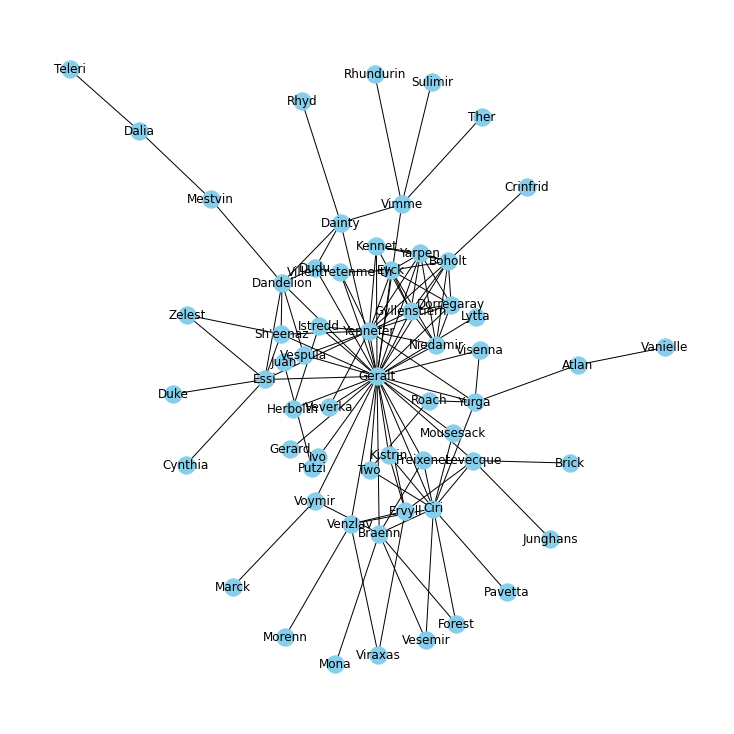

In [22]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [23]:
## Graph viz - Pyvis

from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("witcher.html")

In [24]:
##The most important characters in The Witcher

# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Geralt': 0.5932203389830508,
 'Niedamir': 0.11864406779661017,
 'Eyck': 0.13559322033898305,
 'Dorregaray': 0.11864406779661017,
 'Yennefer': 0.2542372881355932,
 'Yarpen': 0.13559322033898305,
 'Gyllenstiern': 0.13559322033898305,
 'Kennet': 0.0847457627118644,
 'Boholt': 0.15254237288135594,
 'Crinfrid': 0.01694915254237288,
 'Villentretenmerth': 0.05084745762711865,
 'Istredd': 0.05084745762711865,
 'Herbolth': 0.03389830508474576,
 'Ivo': 0.01694915254237288,
 'Two': 0.05084745762711865,
 'Vespula': 0.05084745762711865,
 'Dainty': 0.0847457627118644,
 'Dandelion': 0.11864406779661017,
 'Rhyd': 0.01694915254237288,
 'Vimme': 0.0847457627118644,
 'Ther': 0.01694915254237288,
 'Sulimir': 0.01694915254237288,
 'Rhundurin': 0.01694915254237288,
 'Dudu': 0.05084745762711865,
 "Sh'eenaz": 0.0847457627118644,
 'Dalia': 0.03389830508474576,
 'Teleri': 0.01694915254237288,
 'Mestvin': 0.03389830508474576,
 'Essi': 0.11864406779661017,
 'Gerard': 0.01694915254237288,
 'Zelest': 0.0338983050

<AxesSubplot:>

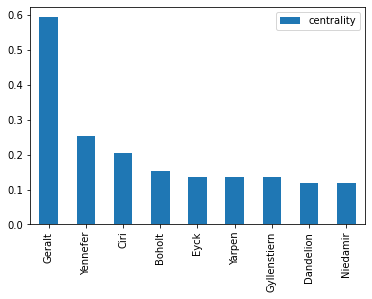

In [25]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<AxesSubplot:>

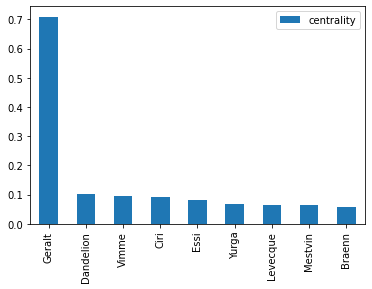

In [26]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<AxesSubplot:>

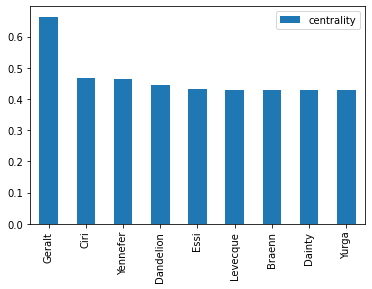

In [27]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [28]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

## Community detection

In [29]:
import community as community_louvain

communities = community_louvain.best_partition(G)
communities

{'Geralt': 2,
 'Niedamir': 1,
 'Eyck': 1,
 'Dorregaray': 1,
 'Yennefer': 1,
 'Yarpen': 1,
 'Gyllenstiern': 1,
 'Kennet': 1,
 'Boholt': 1,
 'Crinfrid': 1,
 'Villentretenmerth': 1,
 'Istredd': 2,
 'Herbolth': 2,
 'Ivo': 2,
 'Two': 2,
 'Vespula': 5,
 'Dainty': 5,
 'Dandelion': 5,
 'Rhyd': 5,
 'Vimme': 5,
 'Ther': 5,
 'Sulimir': 5,
 'Rhundurin': 5,
 'Dudu': 5,
 "Sh'eenaz": 4,
 'Dalia': 5,
 'Teleri': 5,
 'Mestvin': 5,
 'Essi': 4,
 'Gerard': 2,
 'Zelest': 4,
 'Duke': 4,
 'Veverka': 2,
 'Juan': 0,
 'Putzi': 0,
 'Cynthia': 4,
 'Braenn': 3,
 'Ciri': 3,
 'Marck': 3,
 'Voymir': 3,
 'Ervyll': 3,
 'Kistrin': 3,
 'Vesemir': 3,
 'Freixenet': 3,
 'Venzlav': 3,
 'Viraxas': 3,
 'Morenn': 3,
 'Mona': 3,
 'Forest': 3,
 'Pavetta': 3,
 'Levecque': 3,
 'Junghans': 3,
 'Brick': 3,
 'Mousesack': 3,
 'Yurga': 2,
 'Visenna': 2,
 'Atlan': 2,
 'Vanielle': 2,
 'Lytta': 2,
 'Roach': 2}

In [30]:
nx.set_node_attributes(G, communities, 'group')


In [35]:
com_net = Network(notebook = True, width="1650px", height="750px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("witcher_communities.html")

In [32]:
## Evolution of characters' importance

In [33]:
from lib.utils.functions import *

ModuleNotFoundError: No module named 'lib.utils'